## REINFORCE 알고리즘 예제로 이해하기: CartPole-v1

In [ ]:
%pip install gymnasium numpy matplotlib torch

## 필요한 라이브러리 임포트, 환경 생성

In [ ]:
import gymnasium as gym
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Categorical
import matplotlib.pyplot as plt
from collections import deque

# 일관된 결과를 위한 시드 설정
torch.manual_seed(42)
np.random.seed(42)

# CartPole-v1 환경 생성
env = gym.make('CartPole-v1')
input_dim = env.observation_space.shape[0]  # 상태 차원 (4)
output_dim = env.action_space.n  # 행동 차원 (2)

## Policy Network 정의

In [12]:
# 정책 네트워크 정의
class PolicyNetwork(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim=128):
        super(PolicyNetwork, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.softmax(x, dim=1)
    
    def select_action(self, state):
        state = torch.FloatTensor(state).unsqueeze(0)
        probs = self.forward(state)
        m = Categorical(probs)
        action = m.sample()
        log_prob = m.log_prob(action)
        return action.item(), log_prob

## REINFORCE 알고리즘 기반 학습 정의

In [13]:
def train_reinforce(num_episodes=1000, gamma=0.99, lr=0.01):
    # 정책 네트워크와 옵티마이저 초기화
    policy = PolicyNetwork(input_dim, output_dim)
    optimizer = optim.Adam(policy.parameters(), lr=lr)
    
    # 결과 기록용
    rewards_history = []
    running_reward = deque(maxlen=100)
    
    for episode in range(num_episodes):
        # 새로운 에피소드 시작
        state, _ = env.reset()  # Gymnasium에서는 reset()이 (state, info) 반환
        episode_rewards = []
        log_probs = []
        done = False
        
        # 에피소드 실행
        while not done:
            # 행동 선택
            action, log_prob = policy.select_action(state)
            
            # 환경에서 한 스텝 진행
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            
            # 경험 저장
            log_probs.append(log_prob)
            episode_rewards.append(reward)
            
            state = next_state
        
        # 에피소드 종료 후 총 보상 계산
        episode_reward = sum(episode_rewards)
        rewards_history.append(episode_reward)
        running_reward.append(episode_reward)
        
        # 할인된 보상(returns) 계산
        returns = []
        discounted_reward = 0
        
        for reward in reversed(episode_rewards):
            discounted_reward = reward + gamma * discounted_reward
            returns.insert(0, discounted_reward)
            
        # 리턴 정규화
        returns = torch.FloatTensor(returns)
        returns = (returns - returns.mean()) / (returns.std() + 1e-9)
        
        # 정책 손실 계산
        policy_loss = []
        for log_prob, R in zip(log_probs, returns):
            policy_loss.append(-log_prob * R)  # 정책 그래디언트 공식
        
        policy_loss = torch.cat(policy_loss).sum()
        
        # 네트워크 업데이트
        optimizer.zero_grad()
        policy_loss.backward()
        optimizer.step()
        
        # 학습 진행상황 출력
        if episode % 20 == 0:
            avg_reward = np.mean(running_reward) if running_reward else 0
            print(f'에피소드 {episode}: 보상 = {episode_reward}, 평균 보상 = {avg_reward:.2f}')
        
        # 목표 달성 체크 (CartPole-v1은 475점 이상이면 해결로 간주)
        if len(running_reward) == 100 and np.mean(running_reward) >= 475:
            print(f'환경 해결! {episode} 에피소드 후 평균 보상: {np.mean(running_reward):.2f}')
            break
            
    return policy, rewards_history

## 학습 결과 시각화 함수 정의

In [16]:
def plot_results(rewards):
    plt.figure(figsize=(10, 6))
    plt.plot(rewards)
    plt.title('REINFORCE Learning Progress - CartPole-v1')
    plt.xlabel('Episodes')
    plt.ylabel('Episode Rewards')
    plt.grid(True)
    
    # 이동 평균선 추가
    window_size = 100
    if len(rewards) >= window_size:
        moving_avg = np.convolve(rewards, np.ones(window_size)/window_size, mode='valid')
        plt.plot(range(window_size-1, len(rewards)), moving_avg, 'r-', label=f'{window_size}-Episode Moving Average')
        plt.legend()
    
    plt.show()

def test_agent(policy, env, num_episodes=3, render=False):
    for episode in range(num_episodes):
        state, _ = env.reset()
        episode_reward = 0
        done = False
        step = 0
        
        while not done:
            if render:
                env.render()
            
            # 행동 선택 (학습된 정책 사용)
            action, _ = policy.select_action(state)
            
            # 환경에서 한 스텝 진행
            state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            
            episode_reward += reward
            step += 1
        
        print(f'테스트 에피소드 {episode+1}: 보상 = {episode_reward}, 스텝 = {step}')
    
    env.close()

### 정의한 함수 실행 및 에이전트 테스트

에피소드 0: 보상 = 25.0, 평균 보상 = 25.00
에피소드 20: 보상 = 21.0, 평균 보상 = 19.95
에피소드 40: 보상 = 84.0, 평균 보상 = 35.66
에피소드 60: 보상 = 110.0, 평균 보상 = 65.51
에피소드 80: 보상 = 78.0, 평균 보상 = 82.42
에피소드 100: 보상 = 91.0, 평균 보상 = 82.45
에피소드 120: 보상 = 164.0, 평균 보상 = 109.49
에피소드 140: 보상 = 365.0, 평균 보상 = 159.14
에피소드 160: 보상 = 248.0, 평균 보상 = 223.91
에피소드 180: 보상 = 500.0, 평균 보상 = 281.79
에피소드 200: 보상 = 500.0, 평균 보상 = 359.42
에피소드 220: 보상 = 25.0, 평균 보상 = 373.37
에피소드 240: 보상 = 277.0, 평균 보상 = 346.12
에피소드 260: 보상 = 254.0, 평균 보상 = 332.78
에피소드 280: 보상 = 197.0, 평균 보상 = 317.33
에피소드 300: 보상 = 172.0, 평균 보상 = 284.78
에피소드 320: 보상 = 161.0, 평균 보상 = 273.96
에피소드 340: 보상 = 143.0, 평균 보상 = 274.14
에피소드 360: 보상 = 35.0, 평균 보상 = 216.67
에피소드 380: 보상 = 104.0, 평균 보상 = 166.29
에피소드 400: 보상 = 129.0, 평균 보상 = 130.76
에피소드 420: 보상 = 128.0, 평균 보상 = 121.90
에피소드 440: 보상 = 231.0, 평균 보상 = 125.18
에피소드 460: 보상 = 250.0, 평균 보상 = 171.40
에피소드 480: 보상 = 239.0, 평균 보상 = 199.28
에피소드 500: 보상 = 220.0, 평균 보상 = 220.22
에피소드 520: 보상 = 252.0, 평균 보상 = 238.92
에피소드 540: 보상 = 252.0

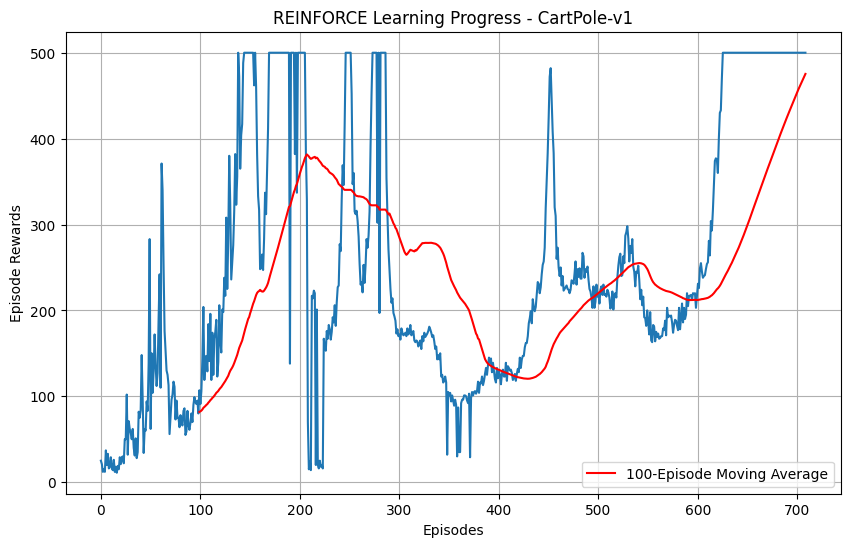

테스트 에피소드 1: 보상 = 500.0, 스텝 = 500
테스트 에피소드 2: 보상 = 500.0, 스텝 = 500
테스트 에피소드 3: 보상 = 500.0, 스텝 = 500


In [17]:
# 학습 실행
trained_policy, rewards_history = train_reinforce(num_episodes=1000)

# 결과 시각화
plot_results(rewards_history)

# 학습된 에이전트 테스트
test_agent(trained_policy, env)

### REINFORCE 알고리즘 요약:

1. 몬테카를로 정책 그래디언트:
   - 에피소드가 완전히 끝난 후에 업데이트를 수행
   - 각 타임스텝에서의 기대 리턴(G_t)을 계산


2. 핵심 수식:
   - 목표: 기대 보상 E[R_t] 최대화
   - 정책 그래디언트: ∇J(θ) = E[∇log π(a|s;θ) · R]
   - 파라미터 업데이트: θ = θ + α∇log π(a|s;θ) · R


3. 실제 구현의 핵심:
   - 정책 네트워크: 상태 -> 행동 확률 매핑
   - 몬테카를로 리턴 계산: G_t = Σ(γ^k · r_{t+k+1})
   - 학습 안정화: 리턴 정규화


4. 장점과 한계:
   - 장점: 구현이 간단하고, 직접적으로 정책을 최적화
   - 한계: 높은 분산, 샘플 효율성 낮음


5. 개선 방향:
   - 기준선(baseline) 도입: Advantage 사용 (A = Q - V)
   - Actor-Critic 방법: 별도의 가치 함수 학습
